In [1]:
import pandas as pd

In [2]:
bioassay = pd.read_csv('../AID_1706_datatable_all.csv.gz',compression='gzip',skiprows=range(1,5))

In [3]:
# Get what is usefull, and rename to match VS naming scheme
df = bioassay[['PUBCHEM_SID','PUBCHEM_ACTIVITY_OUTCOME','Inhibition']]
df.columns=['id','kind','Inhibition']

In [4]:
# Read qvina docking scores, and fix wrong HEADER
qvina = pd.read_csv('DockFlow_qvina.csv.gz',compression='gzip')
qvina.columns=['id','pose','qvina']

# Read Rescores.
vina    = pd.read_csv('rescore_vina.csv.gz',compression='gzip')
smina   = pd.read_csv('rescore_smina.csv.gz',compression='gzip')
vinardo = pd.read_csv('rescore_vinardo.csv.gz',compression='gzip')

# Read RF-ScoreVS_v2 rescore
rfscore_vs_v2 = pd.read_csv('rfscore.csv.gz',compression='gzip')
rfscore_vs_v2.columns=['pose','id','RFScoreVS_v2']

/home/caio/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Concatenate all into "data"
data = pd.merge(df,rfscore_vs_v2,on='id')
data['RFScoreVS_v2'] = pd.to_numeric(data['RFScoreVS_v2'])

In [6]:
data = pd.merge(data,qvina,  on=['id','pose'])
data['qvina'] = pd.to_numeric(data['qvina'])

In [7]:
data = pd.merge(data,vina,   on=['id','pose'])
data['vina'] = pd.to_numeric(data['vina'])

In [8]:
data = pd.merge(data,smina,  on=['id','pose'])
data['smina'] = pd.to_numeric(data['smina'])

In [9]:
data = pd.merge(data,vinardo,on=['id','pose'])
data['vinardo'] = pd.to_numeric(data['vinardo'])

In [10]:
data

,id,kind,Inhibition,pose,RFScoreVS_v2,qvina,vina,smina,vinardo
0,842121,Inactive,-1.55,1,5.950024,-5.6,-5.63480,-5.84857,-6.46782
1,842121,Inactive,-1.55,2,5.959857,-5.6,-4.91094,-5.04426,-5.03265
2,842121,Inactive,-1.55,3,5.962348,-5.5,-5.13135,-5.26157,-5.79712
3,842121,Inactive,-1.55,4,5.966875,-5.4,-5.27989,-5.44041,-6.66113
4,842121,Inactive,-1.55,5,5.973818,-5.4,-5.45266,-5.58670,-5.88591
...,...,...,...,...,...,...,...,...,...
547816,51090821,Inactive,0.19,6,5.955770,-6.2,-6.29844,-6.65426,-6.48510
547817,51090821,Inactive,0.19,7,5.955254,-5.5,-5.81293,-5.85161,-5.68095
547818,51090821,Inactive,0.19,8,5.964141,-5.3,-5.89117,-6.02238,-6.47135
547819,51090821,Inactive,0.19,9,5.951377,-5.3,-5.41285,-6.16561,-6.31044


In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

qvina: 0.405325
vina: 0.402754
smina: 0.401393
vinardo: 0.405618
RFScoreVS_v2: 0.531481


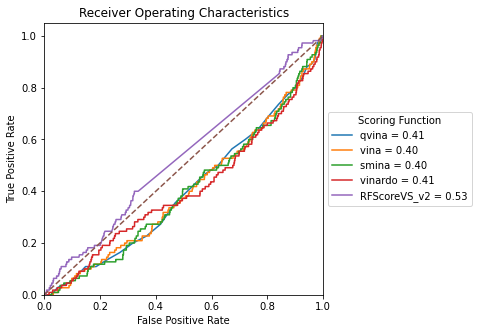

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
for SF in ['qvina','vina','smina','vinardo','RFScoreVS_v2']:
    # 1st top pose according to each scoring function
    df = data.sort_values(SF).groupby('id').head(1)
    fpr, tpr, _ = roc_curve(df['kind'].to_numpy(), df[SF].to_numpy(), pos_label='Active')
    roc_auc = auc(fpr, tpr)
    print(f'{SF}: {roc_auc:>.6f}')
    ax.plot(fpr, tpr, label=f'{SF} = {roc_auc:>.2f}')

# Plot a line
ax.plot([0,1], [0,1], linestyle='--')

# Some legends
ax.set(xlim=[0.0,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver Operating Characteristics')
plt.legend(title='Scoring Function', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [18]:
import seaborn as sns

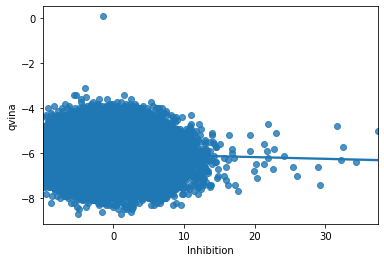

In [14]:
# Só de curiosidade, como está a correlação com a inibição (não espere ser boa... tá um lixo.)

# 1st top pose according to Qvina
df = data.sort_values('qvina').groupby('id').head(1)
sns.regplot(data=df.query('-10 < Inhibition < 40'),x='Inhibition',y='qvina',label=f'QVINA')

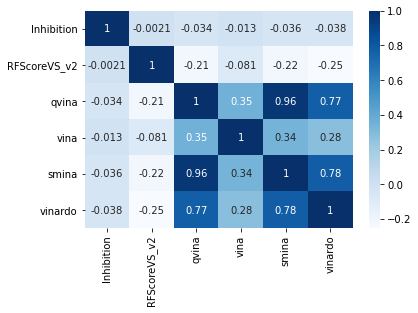

In [14]:
sns.heatmap(data.query('pose == 1').corr(), annot=True, cmap='Blues')

In [15]:
top = pd.melt(data.query('pose == 1'), id_vars=['id','kind','Inhibition'], value_vars=['RFScoreVS_v2','qvina','vina','smina','vinardo'])

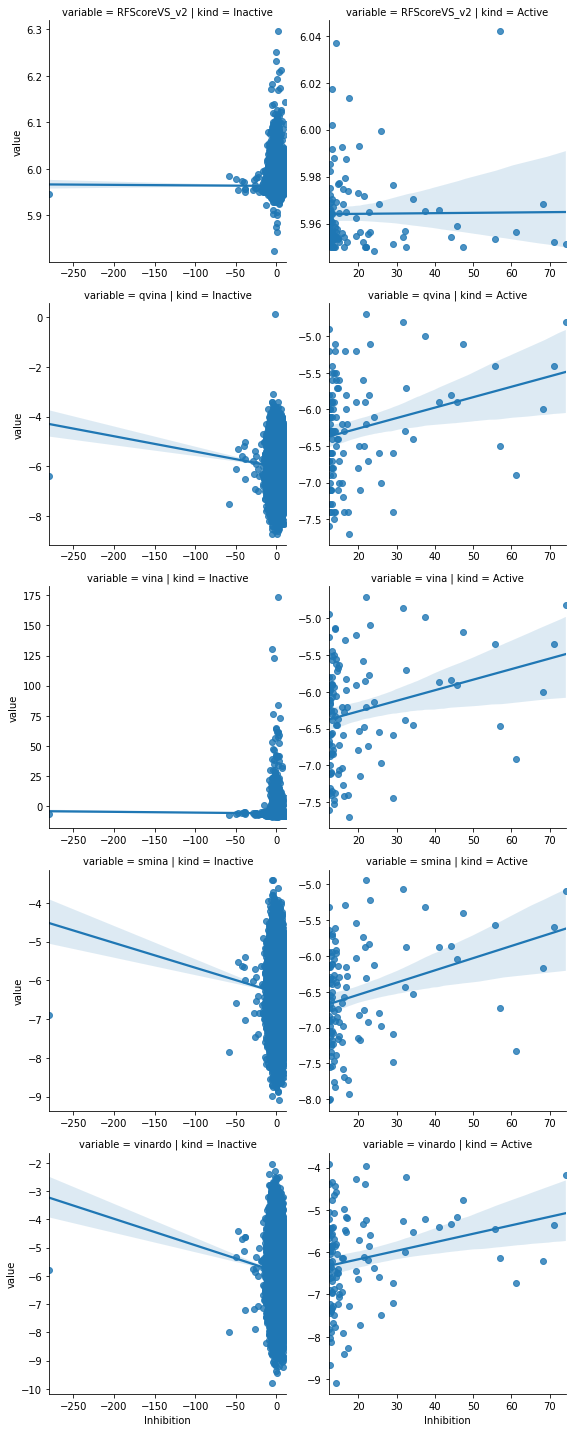

In [19]:
g = sns.FacetGrid(data=top, col='kind', row='variable', sharex=False, sharey=False, height=4)
g.map(sns.regplot,'Inhibition','value').add_legend()
plt.savefig('reg_grid.png')

In [22]:
total = len(data)

In [23]:
copy = data.copy()

In [24]:
for SF in copy[['qvina','vina','smina','vinardo']]:
    # Remove outliers by the IQR method
    Q1   = copy[SF].quantile(0.25)
    Q3   = copy[SF].quantile(0.75)
    IQR  = Q3 - Q1
    copy = copy[~((copy[SF] < (Q1 - 1.5 * IQR))|(copy[SF] > (Q3 + 1.5 * IQR)))]
    
    # # Or Remove outliers by the MAD method
    # M = statistics.median(casp3[SF])
    # MAD = stats.median_absolute_deviation(casp3[SF])
    # casp3 = casp3[~((casp3[SF] < (M - 3 * MAD))|(casp3[SF] > (M + 3 * MAD)))]

In [25]:
print(f'{total - len(copy)} compostos removidos')

10162 compostos removidos


In [25]:
data.query('vina > 0')

,id,kind,Inhibition,pose,RFScoreVS_v2,qvina,vina,smina,vinardo
379,842159,Inactive,0.85,10,5.952754,-4.6,5.45238,-4.90714,-4.46800
849,842206,Inactive,0.18,10,5.972889,-5.1,17.16659,-6.11635,-5.51496
1062,842228,Inactive,-1.08,3,5.961115,-4.8,6.75058,-5.49452,-4.20357
1086,842230,Inactive,-2.11,7,5.954544,-5.1,11.66570,-5.62067,-5.14354
1237,842245,Inactive,-9.66,8,5.959560,-4.8,0.43814,-4.79635,-4.49095
...,...,...,...,...,...,...,...,...,...
546583,51090449,Inactive,-2.81,3,5.954100,-5.6,0.25466,-6.66319,-7.19855
546666,51090459,Inactive,3.81,6,5.950985,-5.3,8.80543,-5.47778,-5.09261
547485,51090722,Inactive,1.20,5,5.953237,-5.5,30.14013,-6.55828,-5.54288
547506,51090729,Inactive,-1.97,6,5.967154,-5.6,14.57490,-6.54590,-5.64942


In [26]:
copy['RFScoreVS_v2'] *= -1

In [27]:
top2 = pd.melt(copy.query('pose == 1'), id_vars=['id','kind','Inhibition'], value_vars=['RFScoreVS_v2','qvina','vina','smina','vinardo'])

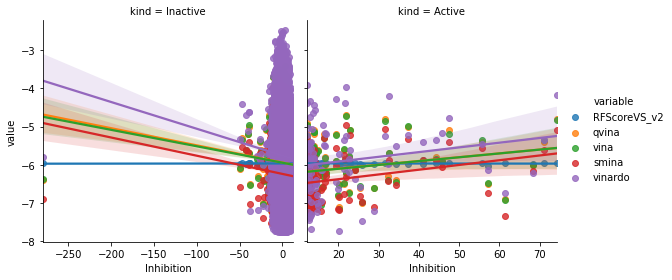

In [34]:
g = sns.FacetGrid(data=top2, col='kind', hue='variable', sharex=False, height=4)
g.map(sns.regplot,'Inhibition','value').add_legend()
plt.savefig('reg_grid.png')

In [30]:
copy.query('pose == 1').corr().iloc[0]

Inhibition      1.000000
RFScoreVS_v2   -0.005228
qvina          -0.026826
vina           -0.025613
smina          -0.028308
vinardo        -0.029496
Name: Inhibition, dtype: float64